In [1]:
import os 
import random
import pickle
from copy import deepcopy

import networkx as nx 
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pulp import *
from layout_utils.layout import Layout
from layout_utils.simulation import Order, OrderPickEvent, run_simulation, Agent, s_shape
import datetime
from layout_utils.simulation import sim_loop
from layout_utils.graph_tools import viz_graph
from utils import render_warehouse, calc_product_freq
from data.instance_loader import InstanceLoader

In [11]:
def gen_pos(G: nx.Graph):
    pos_dict = {}
    for node in G.nodes():
        pos_dict[node] = np.array([node[0], node[1], node[2]])
    return pos_dict

In [5]:
instance = InstanceLoader()
instance.extract_info()

In [6]:
instance.general_info

{'NAME': 'Pr_20_1_20_Store1_01.txt',
 'TYPE': 'Order_batching',
 'COMMENT': 'Bahï¿½eci and ï¿½ncan (2021)',
 'PICKER_CAPACITY': '20',
 'LAYOUT': 'single-block',
 'NUM_AISLES': '10',
 'NUM_CELLS': '10',
 'DEPOT_AISLE': '0',
 'DEPOT_LOCATION': 'bottom',
 'DISTANCE_AISLE_TO_AISLE': '2.4',
 'DISTANCE_CELL_TO_CELL': '1',
 'DISTANCE_TOP_TO_CELL': '1',
 'DISTANCE_BOTTOM_TO_CELL': '1',
 'DISTANCE_TOP_OR_BOTTOM_TO_DEPOT': '0'}

In [15]:
layout_info = instance.general_info
aisles = int(layout_info["NUM_AISLES"])
locations = int(layout_info["NUM_CELLS"])
inter_cell_dist = float(layout_info["DISTANCE_CELL_TO_CELL"])
inter_aisle_dist = float(layout_info["DISTANCE_AISLE_TO_AISLE"])
G = nx.Graph()
G.add_node((0,0,0)) #depot
G.add_node((1,1,0)) #first aisle
G.add_node((1,2+locations,0)) #first aisle
last_mid = (1,1,0)
for l in range(locations):
    location_left= (0, l+2, 0)
    location_right = (2, l+2, 0)
    location_mid = (1, l+2, 0)

    G.add_node(location_left)
    G.add_node(location_right)
    G.add_node(location_mid)

    G.add_edge(location_left, location_mid, weight=1)
    G.add_edge(location_right, location_mid, weight=1)

    G.add_edge(last_mid, location_mid, weight=1)
    last_mid = location_mid
G.add_edge(last_mid, (1,2+locations,0), weight=1)
    
start = 1
last_aisle_start = (1,1,0)
last_aisle_end = (1,2+locations,0)
for a in range(aisles-1):
    start += 3
    aisle_start = (start, 1, 0)
    aisle_end = (start, 2+locations, 0)
    G.add_node(aisle_start)
    G.add_node(aisle_end)
    # if a > 0:
    last_mid = aisle_start
    for l in range(locations):
        location_left = (start-1, l+2, 0)
        location_right = (start+1, l+2, 0)
        location_mid = (start, l+2, 0)

        G.add_node(location_left)
        G.add_node(location_right)
        G.add_node(location_mid)

        G.add_edge(location_left, location_mid, weight=1)
        G.add_edge(location_right, location_mid, weight=1)

        G.add_edge(last_mid, location_mid, weight=1)
        last_mid = location_mid

    G.add_edge(last_mid, aisle_end, weight=1)

    #G.add_edge(aisle_start, aisle_end, weight=(locations+1)*inter_cell_dist)
    G.add_edge(last_aisle_start, aisle_start, weight=inter_aisle_dist)
    G.add_edge(last_aisle_end, aisle_end, weight=inter_aisle_dist)
    last_aisle_start = aisle_start
    last_aisle_end = aisle_end



In [10]:
aisles = 4
locations = 5
inter_cell_dist = 1
inter_aisle_dist = 3
G = nx.Graph()
G.add_node((0,0,0)) #depot
G.add_node((1,1,0)) #first aisle
G.add_node((1,2+locations,0)) #first aisle
last_mid = (1,1,0)
for l in range(locations):
    location_left= (0, l+2, 0)
    location_right = (2, l+2, 0)
    location_mid = (1, l+2, 0)

    G.add_node(location_left)
    G.add_node(location_right)
    G.add_node(location_mid)

    G.add_edge(location_left, location_mid, weight=1)
    G.add_edge(location_right, location_mid, weight=1)

    G.add_edge(last_mid, location_mid, weight=1)
    last_mid = location_mid
G.add_edge(last_mid, (1,2+locations,0), weight=1)
    
start = 1
last_aisle_start = (1,1,0)
last_aisle_end = (1,2+locations,0)
for a in range(aisles-1):
    start += 3
    aisle_start = (start, 1, 0)
    aisle_end = (start, 2+locations, 0)
    G.add_node(aisle_start)
    G.add_node(aisle_end)
    # if a > 0:
    last_mid = aisle_start
    for l in range(locations):
        location_left = (start-1, l+2, 0)
        location_right = (start+1, l+2, 0)
        location_mid = (start, l+2, 0)

        G.add_node(location_left)
        G.add_node(location_right)
        G.add_node(location_mid)

        G.add_edge(location_left, location_mid, weight=1)
        G.add_edge(location_right, location_mid, weight=1)

        G.add_edge(last_mid, location_mid, weight=1)
        last_mid = location_mid

    G.add_edge(last_mid, aisle_end, weight=1)

    #G.add_edge(aisle_start, aisle_end, weight=(locations+1)*inter_cell_dist)
    G.add_edge(last_aisle_start, aisle_start, weight=inter_aisle_dist)
    G.add_edge(last_aisle_end, aisle_end, weight=inter_aisle_dist)
    last_aisle_start = aisle_start
    last_aisle_end = aisle_end



In [16]:
pos_dict = gen_pos(G)

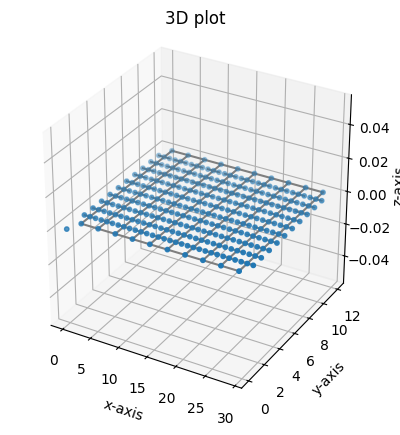

In [17]:
viz_graph(G, pos_dict)

In [22]:
layout_info

{'NAME': 'Pr_20_1_20_Store1_01.txt',
 'TYPE': 'Order_batching',
 'COMMENT': 'Bahï¿½eci and ï¿½ncan (2021)',
 'PICKER_CAPACITY': '20',
 'LAYOUT': 'single-block',
 'NUM_AISLES': '10',
 'NUM_CELLS': '10',
 'DEPOT_AISLE': '0',
 'DEPOT_LOCATION': 'bottom',
 'DISTANCE_AISLE_TO_AISLE': '2.4',
 'DISTANCE_CELL_TO_CELL': '1',
 'DISTANCE_TOP_TO_CELL': '1',
 'DISTANCE_BOTTOM_TO_CELL': '1',
 'DISTANCE_TOP_OR_BOTTOM_TO_DEPOT': '0'}

In [24]:
layout_info = instance.general_info
aisles = int(layout_info["NUM_AISLES"])
locations = int(layout_info["NUM_CELLS"])
inter_cell_dist = float(layout_info["DISTANCE_CELL_TO_CELL"])
inter_aisle_dist = float(layout_info["DISTANCE_AISLE_TO_AISLE"])
G = nx.Graph()
depot=(int(layout_info["DEPOT_AISLE"]),0,0)
G.add_node(depot) #depot
    
start = 1
last_aisle_start = (start,1,0)
last_aisle_end = (start,2+locations,0)
G.add_edge(depot, (7, 1, 0), weight=1.5)
for a in range(aisles):
    aisle_start = (start, 1, 0)
    aisle_end = (start, 2+locations, 0)
    G.add_node(aisle_start)
    G.add_node(aisle_end)
    # if a > 0:
    last_mid = aisle_start
    for l in range(locations):
        location_left = (start-1, l+2, 0)
        location_right = (start+1, l+2, 0)
        location_mid = (start, l+2, 0)

        G.add_node(location_left)
        G.add_node(location_right)
        G.add_node(location_mid)

        G.add_edge(location_left, location_mid, weight=1)
        G.add_edge(location_right, location_mid, weight=1)

        G.add_edge(last_mid, location_mid, weight=inter_cell_dist)
        last_mid = location_mid

    G.add_edge(last_mid, aisle_end, weight=1)

    G.add_edge(last_aisle_start, aisle_start, weight=inter_aisle_dist)
    G.add_edge(last_aisle_end, aisle_end, weight=inter_aisle_dist)
    last_aisle_start = aisle_start
    last_aisle_end = aisle_end
    start += 3

In [25]:
pos_dict = gen_pos(G)

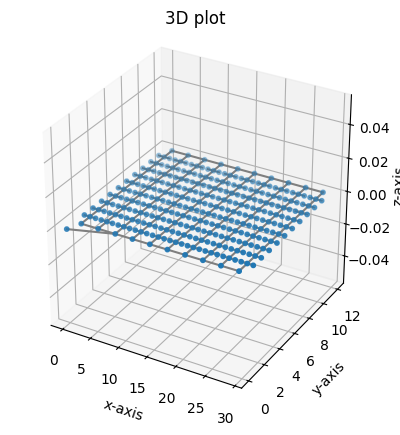

In [26]:
viz_graph(G, pos_dict)

In [27]:
import pyomo.environ as pyo 

In [22]:
aisles

4

In [28]:
n_orders = 5
n_batches = 5
capacity = 10

model = pyo.ConcreteModel("BATCHING")
model.Aisles = pyo.RangeSet(1, aisles) 
model.Orders = pyo.RangeSet(1, n_orders)
model.Batches = pyo.RangeSet(1, n_batches)

weights = [2, 2, 2, 2, 3]
model.mi = pyo.Param(model.Orders, initialize=dict(enumerate(weights, start=1)))
model.dik = pyo.Param(model.Orders, model.Aisles, initialize={
                                                              (1,1):1, (1,2):0, (1,3):1, (1,4):0,
                                                              (2,1):1, (2,2):1, (2,3):0, (2,4):0,
                                                              (3,1):0, (3,2):1, (3,3):1, (3,4):0,
                                                              (4,1):0, (4,2):1, (4,3):0, (4,4):1,
                                                              (5,1):1, (5,2):0, (5,3):1, (5,4):0,})
model.M = pyo.Param(within=pyo.NonNegativeReals, initialize=1000)
model.vj = pyo.Var(model.Batches, domain=pyo.Integers)

model.yjk = pyo.Var(model.Batches, model.Aisles, domain=pyo.Binary)
model.pjk = pyo.Var(model.Batches, model.Aisles, domain=pyo.Binary)

model.cj = pyo.Var(model.Batches, domain=pyo.Binary)

model.xij = pyo.Var(model.Orders, model.Batches, domain=pyo.Binary)
model.hjR = pyo.Var(model.Batches, domain=pyo.PositiveReals)
model.hjL = pyo.Var(model.Batches, domain=pyo.PositiveReals)
model.ujk = pyo.Var(model.Batches, model.Aisles, domain=pyo.PositiveReals)

def objective(model):
    return 2 * pyo.quicksum(
        model.ujk[j,k] for j in model.Batches for k in model.Aisles
) 
+ 2 * pyo.quicksum(
    model.hjR[j] * model.hjL[j] for j in model.Batches
)
+ 2 * inter_aisle_dist * pyo.quicksum(
    model.vj[j] - model.cj[j] for j in model.Batches
)

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)

def constraint_batch_assignment(model, i_order):
    return pyo.quicksum(model.xij[i_order,j] for j in model.Batches) == 1
model.constraint_batch_assignment = pyo.Constraint(model.Orders, rule=constraint_batch_assignment)

def constraint_batch_capacity(model, i_order):
    return pyo.quicksum(model.mi[i_order]*model.xij[i_order,j] for j in model.Batches) <= capacity
model.constraint_batch_capacity = pyo.Constraint(model.Orders, rule=constraint_batch_capacity)

# def constraint_batch_guarantee(model, i, j):
#     model.xij[i,j] <= x[j,j] 

def constraint_1(model, j, k, i):
    return model.yjk[j,k] <= pyo.quicksum(
        model.dik[i,k] * model.xij[i,j] 
        for j in model.Batches 
        for k in model.Aisles)
model.constraint_1 = pyo.Constraint(model.Batches, model.Aisles, model.Orders, rule=constraint_1)

def constraint_2(model, j, k, i):
    return pyo.quicksum(
        model.dik[i,k] * model.xij[i,j] 
        for j in model.Batches 
        for k in model.Aisles) <= model.M*model.yjk[j,k]
model.constraint_2 = pyo.Constraint(model.Batches, model.Aisles, model.Orders, rule=constraint_2)

ERROR: Rule failed when generating expression for Constraint constraint_1 with
index (1, 1, 1): ValueError: Error retrieving immutable Param value (dik[(1,
5)]):
            The Param value is undefined and no default value is specified.
ERROR: Constructing component 'constraint_1' from data=None failed:
        ValueError: Error retrieving immutable Param value (dik[(1, 5)]):
    	The Param value is undefined and no default value is specified.


ValueError: Error retrieving immutable Param value (dik[(1, 5)]):
	The Param value is undefined and no default value is specified.

In [27]:
opt = pyo.SolverFactory('glpk')
opt.solve(model)

solver 'glpk'


ApplicationError: No executable found for solver 'glpk'

In [14]:
warehouse.nodes_list.index((3,3,0))

45

In [15]:
assignment = [18,30, 42, 21, 33, 45]

In [16]:
warehouse.add_assignment(assignment)

In [17]:
orders = [[0, 1, 2, 3, 4, 5]]

In [18]:
product_freq = calc_product_freq([0, 1, 2, 3, 4, 5], orders)

In [19]:
fig = render_warehouse(warehouse, warehouse.storage_assignment, product_freq)

In [20]:
fig.show()

In [21]:
from layout_utils.simulation import aisle_to_sku

In [81]:
route, line, distance, zugriff = sim_loop("s_shape", orders, warehouse, (6,1,0))

In [82]:
distance

30.0

In [83]:
storage_assignment_heuristic = deepcopy(warehouse.layout_grid)
walkable_locs = np.where(warehouse.layout_grid == 0)

for i, loc in enumerate(assignment):
    storage_assignment_heuristic[warehouse.nodes_list[loc]] = i 


In [84]:
route = np.array(route[0])
line = np.array(line[0])

node_xyz = np.array([warehouse.pos_dict[v] for v in sorted(warehouse.graph)])
edge_xyz = np.array([(warehouse.pos_dict[u], warehouse.pos_dict[v]) for u, v in warehouse.graph.edges()])

# data = []
# for x, y, z in zip(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2]):
#     data_point = storage_frequence_heu[x,y,z]
#     data.append(data_point)

assignment = []
for x, y, z in zip(node_xyz.T[0], node_xyz.T[1], node_xyz.T[2]):
    assignment_point = storage_assignment_heuristic[x,y,z]
    assignment.append(assignment_point)

trace = go.Scatter3d(customdata=np.stack((assignment),axis=-1), hovertemplate = 'x: %{x}<br>y: %{y}<br>z: %{z}<br>Cluster<br>Product: %{customdata[1]}',
x = node_xyz.T[0], y = node_xyz.T[1], z = node_xyz.T[2],mode = 'markers', marker = dict(
    size = 12)
)

lines = go.Scatter3d(
    x=line.T[0],
    y=line.T[1],
    z=line.T[2],
    mode='lines',
    line=dict(color='red', width=10),  # Customize line properties
)

frames=[go.Frame(data=[go.Scatter3d(
    x=[route.T[0][i]],
    y=[route.T[1][i]],
    z=[route.T[2][i]],
    mode='markers',
    marker=dict(color='blue', size=10),  # Customize line properties
) ]) for i in range(len(route.T[0])-1)]

layout=go.Layout(
        xaxis=dict(range=[0, 40], autorange=False),
        yaxis=dict(range=[0, 40], autorange=False),
        title="Start Title",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])]
    )
fig = go.Figure(data = [trace, lines], layout = layout, frames = frames)
fig.update_traces(marker_size = 5)
fig.show()

In [85]:
warehouse_heatmap = px.imshow(warehouse.layout_grid[:,:,0])
warehouse_heatmap